In [24]:
import pandas as pd
from tqdm import notebook
from utils.regex_fx import remove_mention, remove_non_ascii, remove_emojis, remove_urls, remove_nonalpha, remove_extra_spaces, remove_special_words, remove_rt, remove_single_char, remove_numbers
import spacy
import re
import numpy as np
nlp = spacy.load("en_core_web_sm")
from gensim.models import LdaMulticore, Phrases
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from collections import Counter

import itertools
from fuzzywuzzy import fuzz

In [38]:
isot_true = pd.read_csv('isot/True.csv')
isot_false = pd.read_csv('isot/Fake.csv')

In [20]:
isot_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [21]:
isot_true_politics = isot_true[isot_true['subject']=='politicsNews']

In [44]:
isot_false.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [51]:
categories_to_keep = ['politics']
isot_false_politics = isot_false[isot_false['subject'].isin(categories_to_keep)]


In [48]:
def cleanup(text):
    res = remove_mention(text)
    res = remove_non_ascii(res)
    res = res.lower()
    res = remove_urls(res)
    res = remove_rt(res)
    res = remove_single_char(res)
    res = remove_numbers(res)
    res = remove_emojis(res)
    res = remove_nonalpha(res)
    res = remove_extra_spaces(res)
    res = remove_special_words(res)
    return res

In [36]:
isot_true_cleaned = []
for item in isot_true_politics.text.to_list():
    isot_true_cleaned.append(cleanup(item))
isot_true_politics.text = isot_true_cleaned

/Users/vangelistrikoupis/miniforge3/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [52]:
isot_false_cleaned = []
for item in isot_false_politics.text.to_list():
    isot_false_cleaned.append(cleanup(item))
isot_false_politics.text = isot_false_cleaned

/Users/vangelistrikoupis/miniforge3/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [54]:
isot_false_news = isot_false_news.sample(frac=0.5)

In [55]:
text_list = isot_true_politics.text.to_list() + isot_false_news.text.to_list()

In [56]:
processed_texts = [text for text in notebook.tqdm(nlp.pipe(text_list, 
                                                n_process=-1, # maximum number of threads
                                                disable=["ner", "parser"]),
                                                total=len(text_list))]

  0%|          | 0/17707 [00:00<?, ?it/s]

In [57]:
allow_postags = set(['NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'])
# tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts)]
tokenized_texts = [[word.lemma_ for word in lemma_  if word.pos_ in allow_postags  if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts)]


  0%|          | 0/17707 [00:00<?, ?it/s]

In [58]:
def process_tokenized(tokenized_texts):
    # tokenized_texts = make_n_grams(tokenized_texts)
    flatten = lambda t: [item for sublist in t for item in sublist]
    flattened = flatten(tokenized_texts)
    counts = Counter(flattened)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flattened, tokenized_texts

In [59]:
tokenized_obj = process_tokenized(tokenized_texts)
counts_combined, common_combined, flattened_combined, tokenized_texts_combined = tokenized_obj

In [60]:
common_combined[:20]

[('say', 71891),
 ('state', 25744),
 ('republican', 22762),
 ('president', 20493),
 ('house', 15369),
 ('reuter', 14436),
 ('s', 13424),
 ('trump', 13300),
 ('people', 12639),
 ('tell', 12291),
 ('campaign', 12049),
 ('washington', 10404),
 ('election', 10155),
 ('white', 10015),
 ('official', 9680),
 ('year', 9615),
 ('clinton', 9463),
 ('include', 9340),
 ('Trump', 9275),
 ('government', 9181)]

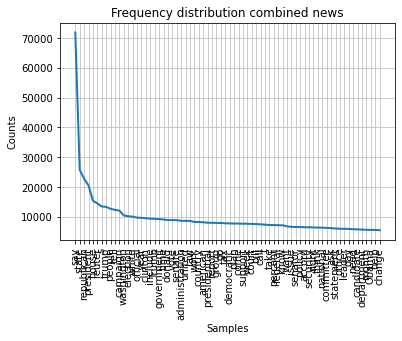

<AxesSubplot:title={'center':'Frequency distribution combined news'}, xlabel='Samples', ylabel='Counts'>

In [61]:
import nltk
from nltk import FreqDist
fdist_filtered = FreqDist(counts_combined)
fdist_filtered.plot(70,title='Frequency distribution combined news')

In [62]:
def compute_coherence_values(texts, start, step, limit, topn):
    dictionary = Dictionary(texts) # get the vocabulary
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    coherence_values = []
    model_list = []
    for num_topics in notebook.tqdm(range(start, limit, step)):
        model = LdaMulticore( corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = 0.1, iterations = 1000)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v', topn=topn)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [63]:
all_scores = []
for n in range(5, 15, 5):
    model_list, coherence_values = compute_coherence_values(texts=tokenized_texts, start=1, step=1, limit=40, topn=n)
    all_scores.append(coherence_values)

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

In [64]:
all_scores = np.array(all_scores)
avg_scores = np.average(all_scores, axis=0)
print(avg_scores)

[0.37626648 0.37270336 0.41129289 0.38379181 0.40077047 0.4435545
 0.42811919 0.41720201 0.44030024 0.45047987 0.45660629 0.42401173
 0.43443793 0.44594333 0.46479332 0.40570582 0.44041585 0.44946584
 0.43780029 0.45145339 0.4397162  0.45548631 0.43778778 0.44352276
 0.43836529 0.44604223 0.43605805 0.43827797 0.46537942 0.42103334
 0.49264432 0.48953568 0.48966166 0.4929464  0.4968983  0.49874336
 0.48893495 0.47301924 0.46362333]
